И снова пррриветик! Перед тобой очередное захватывающее домашнее задание по АБ-тестированию. Возьми чай или кофе, усаживайся поудобнее, настрой музыку в свой ритм, и поехали!

In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from tqdm.auto import tqdm
from collections.abc import Iterable
from scipy.optimize import curve_fit
from statsmodels.stats.proportion import proportion_confint

sns.set(style='whitegrid', palette='Set2')

In [270]:
num_users = 150000    # количество пользователей
pre_period = 3    # Длительность пре-периода: обе выборки контрольные
exp_period = 14   # Длительность эксперимента
post_period = 4   # Длительность пост-периода: для post-period подхода

avg_usage_distr = sps.expon(scale=2000)           # распределение на avg_daily_usage
shows_up_distr = sps.bernoulli(p=0.5)             # распределение на shows_up
daily_variation_distr = sps.norm(loc=1, scale=4)  # распределение на daily_variation

In [271]:
def generate_raw_data(num_users, period, avg_usage_distr, 
                      shows_up_distr, daily_variation_distr):
    '''
    Генерирует данные описанным выше способом
    
    - num_users - количество пользователей
    - period - длительность эксперимента
    - avg_usage_distr - распределения на avg_daily_usage
    - shows_up_distr - распределение на shows_up
    - daily_variation_distr - распределение на daily_variation
        
    Возвращает
        data - DataFrame длины num_users * period
    '''
    
    data= pd.DataFrame(range(num_users), columns=['user_id'])
    data['avg_daily_usage'] = avg_usage_distr.rvs(size=num_users)

    data['day'] = [range(period) for _ in range(num_users)]
    data = data.explode("day")
    data['day'] = data['day'].astype(int)

    data['shows_up'] = shows_up_distr.rvs(size=num_users * period)
    data['daily_variation'] = daily_variation_distr.rvs(size=num_users * period)

    data['daily_usage'] = data['avg_daily_usage'] * data['shows_up'] *\
                          data['daily_variation']
    data.loc[data['daily_usage'] <= 0, 'daily_usage'] = 0
    
    return data

In [272]:
# Посмотрим какие данные сгенерятся
data = generate_raw_data(num_users, pre_period + period + post_period, avg_usage_distr, 
                         shows_up_distr, daily_variation_distr)
split_groups(data, 2)
data

,user_id,avg_daily_usage,day,shows_up,daily_variation,daily_usage,group
0,0,441.040766,0,1,0.538121,237.333411,1
0,0,441.040766,1,1,1.551149,684.119736,1
0,0,441.040766,2,0,-0.200724,0.000000,1
0,0,441.040766,3,1,6.933381,3057.903848,1
0,0,441.040766,4,0,-5.323774,0.000000,1
...,...,...,...,...,...,...,...
149999,149999,1265.739981,16,1,9.540789,12076.157820,1
149999,149999,1265.739981,17,0,3.813980,0.000000,1
149999,149999,1265.739981,18,1,-0.625265,0.000000,1
149999,149999,1265.739981,19,1,-1.232011,0.000000,1


In [5]:
def get_exponential_model(mode):
    '''
    Возвращает функцию для моделирования эффекта mode (novelty или primacy)
    '''
    
    assert mode in ['novelty', 'primacy']
    
    def novelty_model(day, theta, gamma):
        return np.exp(-day * gamma) * theta
    
    def primacy_model(day, theta, gamma):
        return (1 - np.exp(-day * gamma)) * theta
        
    if mode == 'novelty':
        return novelty_model
    else:
        return primacy_model


def split_groups(data, cnt_groups, target_column='group'):
    '''
    Добавляет столбец target_column с номерами групп пользователей в data

    - data - DataFrame с данными
    - cnt_groups - количесто групп, на которые надо поделить пользователей
    - target_column - имя колонки с номером группы
    '''
    
    users = data['user_id'].unique()
    np.random.shuffle(users)
    
    data[target_column] = 0
    
    for group in range(cnt_groups):
        group_idxs = data['user_id'].isin(users[group::cnt_groups])
        data.loc[group_idxs, target_column] = group


def add_effect(data, group, theta, gamma, scale, const_effect=0, mode='novelty', 
               start_day=0, post_period_start=None, post_gamma=None, 
               group_column='group', target_column='daily_usage'):
    '''
    Добавляет эффект в столбец column из распределения 
        N(theta * exp(-gamma * t), scale^2) в случае mode == 'novelty'
        N(theta * (1 - exp(-gamma * t)), scale^2) в случае mode == 'primacy'
    
    - data - DataFrame с данными
    - group - группа пользователей, к которым надо добавить эффект
    - theta, gamma, scale - вышеописанные параметры эффекта
    - const_effect - постоянный эффект от влияния эксперимента
    - mode - определяет природу эффекта: novelty или primacy
    - start_day - номер дня старта эксперимента
    - post_period_start - номер дня старта post period при наличии этого периода 
                          (для случая mode == primacy)
    - post_gamma - скорость отвыкания в post period (по умолчанию = gamma)
    - group_column - колонка с группами
    - target_column - колонка, к которой добавляется эффект
    '''
    
    assert mode in ['novelty', 'primacy']
    assert not (mode == 'novelty' and post_period_start is not None)
    if post_gamma is None:
        post_gamma = gamma
    
    # Выбираем индексы нужной группы
    idxs = (data[group_column] == group) & (data['day'] >= start_day)
    
    experiment_durations = data.loc[idxs, 'day'] - start_day
    
    # Моделируем эффект
    model = get_exponential_model(mode=mode)
    mean = model(experiment_durations, theta, gamma) + const_effect
    
    # Если эффект primacy и передан момент старта постпериода, 
    # то в нем привыкание заменяем отвыканием
    if mode == 'primacy' and post_period_start is not None:
        # Вычисляем theta' - эффект на момент перед началом post-period
        last_le = model(post_period_start - start_day, theta, gamma)
        
        # Отвыкание моделируется той же функцией, что и эффект новизны
        unlearning_model = get_exponential_model(mode='novelty')
        
        # Заменяем привыкание отвыканием
        post_period_idxs = experiment_durations >= post_period_start - start_day
        days_from_start = experiment_durations[post_period_idxs] - (post_period_start - start_day)
        mean[post_period_idxs] = unlearning_model(days_from_start, last_le, post_gamma)
    
    # Генерируем шум и добавляем его с эффектом к данным
    noise = sps.norm(loc=0, scale=scale).rvs(len(mean))
    data.loc[idxs, target_column] += mean + noise


def prepare_data_obs_exp(data, theta, gamma, scale, const_effect=0, start_day=0,
                         mode='novelty', group_column='group', 
                         target_column='daily_usage'):
    '''
    Готовит данные для наблюдательного подхода
    Делит пользователей на две группы, к одной в равных пропорциях добавляет 
        эффект с параметрами из theta, gamma, scale
    
    - data - DataFrame с данными
    - theta, gamma, scale - вышеописанные параметры эффекта 
                            (можно передавать листы параметров)
    - const_effect - постоянный эффект от влияния эксперимента
    - start_day - номер дня старта эксперимента
    - group_column - колонка с группами
    - target_column - колонка, к которой добавляется эффект
    '''
    
    if not isinstance(theta, Iterable):
        theta = [theta]
        gamma = [gamma]
        scale = [scale]
    assert len(theta) == len(gamma) == len(scale)

    # Делим на группы: 2 выборки и каждую выборку еще на num_parts частей, 
    # чтобы к каждой добавить эффект со своими параметрами
    num_parts = len(theta)
    split_groups(data, cnt_groups=2 * num_parts, target_column=group_column)
    for i, (t, g, s) in enumerate(zip(theta, gamma, scale)):
        # Добавляем эффект
        add_effect(data, group=i, theta=t, gamma=g, scale=s, 
                   const_effect=const_effect, mode=mode, start_day=start_day, 
                   group_column=group_column, target_column=target_column)

    # Объединяем группы в выборки
    data.loc[data[group_column] < num_parts, group_column] = 0
    data.loc[data[group_column] >= num_parts, group_column] = 1


def prepare_data_ccd_exp(data, theta, gamma, scale, const_effect=0, start_day=0, 
                         period=period, mode='novelty', group_column='group', 
                         target_column='daily_usage'):
    '''
    Готовит данные для cookie-cookie-day подхода
    Делит пользователей на выборки в количестве равном длине эксперимента: 
        i-ая выборка начинает получать эффект с i-ого дня
    
    - data - DataFrame с данными
    - theta, gamma, scale - вышеописанные параметры эффекта (list или число)
    - const_effect - постоянный эффект от влияния эксперимента
    - start_day - номер дня старта эксперимента
    - period - длительность эксперимента (задает количество выборок)
    - group_column - колонка с группами
    - target_column - колонка, к которой добавляется эффект
    '''
    
    if not isinstance(theta, Iterable):
        theta = [theta]
        gamma = [gamma]
        scale = [scale]
    assert len(theta) == len(gamma) == len(scale)
    
    # Как и в предыдущей функции делим на period * num_parts частей: 
    # period выборок и каждую выборку на num_parts частей
    num_parts = len(theta)
    split_groups(data, cnt_groups=period * num_parts, target_column=group_column)
    for sample_index in range(period):
        for i, (t, g, s) in enumerate(zip(theta, gamma, scale)):
            group = sample_index * num_parts + i
            
            # Добавляем эффект
            add_effect(data, group=group, theta=t, gamma=g, scale=s, 
                       const_effect=const_effect, mode=mode, 
                       start_day=sample_index + start_day, 
                       group_column=group_column, target_column=target_column)

        # Объединяем в выборку
        idxs = (data[group_column] >= sample_index * num_parts) &\
               (data[group_column] < (sample_index + 1) * num_parts)
        data.loc[idxs, group_column] = sample_index


def prepare_data_pp_exp(data, theta, gamma, scale, post_period_start, 
                        post_gamma=None, group_column='group', const_effect=0,
                        start_day=0, target_column='daily_usage'):
    '''
    Готовит данные для post period подхода
    Делит пользователей на две группы, к одной в равных пропорциях добавляет 
        эффект с параметрами из theta, gamma, scale
    
    - data - DataFrame с данными
    - theta, gamma, scale - вышеописанные параметры эффекта 
                            (можно передавать листы параметров)
    - post_period_start - день старта post-period
    - post_gamma - gamma эффекта отвыкания, если отсутствует равна gamma
    - const_effect - постоянный эффект от влияния эксперимента
    - start_day - номер дня старта эксперимента
    - group_column - колонка с группами
    - target_column - колонка, к которой добавляется эффект
    '''
    
    if not isinstance(theta, Iterable):
        theta = [theta]
        gamma = [gamma]
        scale = [scale]
        post_gamma = [post_gamma]
    if post_gamma is None:
        post_gamma = [None] * len(theta)
        
    assert len(theta) == len(gamma) == len(scale) == len(post_gamma)
    
    # Делим на 2 * num_parts частей
    num_parts = len(theta)
    split_groups(data, cnt_groups=2 * num_parts, target_column=group_column)
    for group, (t, g, s, p_g) in enumerate(zip(theta, gamma, scale, post_gamma)):
        # Добавляем эффект
        add_effect(data, group=group, theta=t, gamma=g, scale=s, 
                   const_effect=const_effect, mode='primacy', start_day=start_day, 
                   post_period_start=post_period_start, post_gamma=p_g, 
                   group_column=group_column, target_column=target_column)

    # Объединяем группы в выборки
    data.loc[data[group_column] < num_parts, group_column] = 0
    data.loc[data[group_column] >= num_parts, group_column] = 1


def plot_mean_groups(data, group_column, data_column, method_name='', 
                     start_day=None, post_period_start=None, group_names=None):
    '''
    Рисует для каждой выборки средние значения по дням
    
    - data - DataFrame с данными
    - group_column - название колонки с группами
    - data_column - название колонки с данными
    - method_name - название метода для заголовка
    - start_day - номер дня старта эксперимента (опционально)
    - post_period_start - номер дня начала пост-периода (опционально)
    - group_names - названия групп (опционально)
    '''
    
    if group_names is None:
        group_names = data[group_column].unique()
    
    # Вычисляем среднее для каждой выборки в каждый день
    means = data.groupby([group_column, 'day'])[data_column].mean()
    
    plt.title(f'Среднее по дням в разных выборках\n{method_name}')
    
    for group_id, group_name in zip(sorted(data[group_column].unique()), group_names):
        plt.plot(means.loc[group_id], label=str(group_name))

    if start_day is not None:
        plt.axvline(start_day - 0.5, label='Старт', 
                    color='r', ls='--')
    if post_period_start is not None:
        plt.axvline(post_period_start - 0.5, label='Начало пост-периода', 
                    color='black', ls='--')
        
    plt.legend()
    
    
def plot_ccd_groups(data, group_column, data_column, method_name='', start_day=0, 
                    show_preperiod=False):
    '''
    Рисует выборки в cookie-cookie-day подходе: 
        одна линия - средние значения нулевой выборки по дням, 
        другая линия - в день t = среднее значение выборки t
    
    - data - DataFrame с данными
    - group_column - название колонки с группами
    - data_column - название колонки с данными
    - method_name - название метода для заголовка
    - start_day - номер дня старта эксперимента
    - show_preperiod - рисовать ли значения нулевой выборки до start_day
    '''
    
    # Вычисляем среднее для каждой выборки в каждый день
    means = data.groupby([group_column, 'day'])[data_column].mean().reset_index()
    
    plt.title(f'Среднее по дням в разных выборках\n{method_name}')
    
    if not show_preperiod:
        means = means[means['day'] >= start_day]
    
    sns.lineplot(means[means[group_column] == 0], x='day', y=data_column, 
                 label='Долгосрочный эффект')
    sns.lineplot(means[means['day'] - start_day == means[group_column]], 
                 x='day', y=data_column, 
                 label='Краткосрочный эффект\n(каждый день новая выборка)')

    if start_day > 0 and show_preperiod:
        plt.axvline(start_day - 0.5, label='Старт', 
                    color='r', ls='--')


def plot_diffs(data, obs_cols=None, ccd_cols=None, period=period, 
               theta=None, gamma=None):
    '''
    Строит графики оценки эффекта привыкания, приближающей его экспоненциальной 
    модели и истинного среднего эффекта для случая эффекта новизны
    
    - data - DataFrame с данными
    - obs_cols - пары названий колонок с группой и значениями выборки для 
                 наблюдательного подхода
    - ccd_cols - пары названий колонок с группой и значениями выборки для 
                 cookie-cookie-day подхода
    - period - длина периода
    - theta, gamma - истинные параметры (листы или число)
    '''
    
    days = np.arange(period)
    
    plt.figure(figsize=(10, 6))
    # Поскольку оцениваемый эффект стартует из нуля, тут модель такая же, как и для primacy эффекта
    model = get_exponential_model(mode='primacy')
    
    # Наблюдательный подход
    if obs_cols is not None:
        # Оцениваем эффект: вычисляем разность разностей
        obs_mean = data.groupby([obs_cols[0], 'day'])[obs_cols[1]].mean()
        diff = obs_mean.loc[1] - obs_mean.loc[0]
        diff_in_diff = diff - diff[0]
        
        # Оцениваем параметры модели
        (est_theta, est_gamma), _ = curve_fit(model, 
                                              xdata=days, 
                                              ydata=diff_in_diff.values, 
                                              bounds=([-1e4, 0], [1e4, 1]))
        
        plt.plot(days, diff_in_diff, label=f'diff-in-diff', color='r', alpha=0.5)
        plt.plot(days, model(days, est_theta, est_gamma),  color='r', ls='--',
                 label=f'Экспоненциальная модель - diff-in-diff')
    
    # Cookie-cookie-day подход
    if ccd_cols is not None:
        # Оцениваем эффект
        ccd_exp = data[data[ccd_cols[0]] == 0].groupby(['day'])[ccd_cols[1]].mean()
        ccd_control = data[data[ccd_cols[0]] == data['day']].groupby(['day'])[ccd_cols[1]].mean()
        diff = ccd_control - ccd_exp
        
        # Оцениваем параметры модели
        (est_theta, est_gamma), _ = curve_fit(model, 
                                              xdata=days, 
                                              ydata=diff.values, 
                                              bounds=([-1e4, 0], [1e4, 1]))
        
        plt.plot(days, diff, label=f'cookie-cookie-day', color='b', alpha=0.5)
        plt.plot(days, model(days, est_theta, est_gamma), color='b', ls='--',
                 label=f'Экспоненциальная модель - cookie-cookie-day')
    
    # Строим истинный средний эффект
    if theta is not None and gamma is not None:
        if not isinstance(theta, Iterable):
            theta = [theta]
            gamma = [gamma]
            
        effect = []
        for t, g in zip(theta, gamma):
            effect.append(model(days, t, g))
        
        plt.plot(days, np.mean(effect, axis=0), color='g',
                 label=f'Истинный средний эффект')
    
    plt.title('Эффект привыкания и его оценки экспоненциальными моделями')
    plt.xlabel('Время')
    plt.ylabel('Эффект')
    plt.legend()

In [274]:
def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.
    
    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов
    
    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''
    
    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')
    
    return real_alpha, left_alpha, right_alpha


def draw_interval(
    real_alpha, left_alpha, right_alpha, 
    alpha=0.05, figsize=(7, 2)
):
    import seaborn as sns
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''
    
    with sns.axes_style("whitegrid"):
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2, 
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

---
### Задача 1.

Теперь давай проведем исследование реального уровня значимости и мощности критерия для проверки гипотезы об отсутствии эффекта привыкания $\mathsf{H}_0\colon \delta_t = 0$ для наблюдательного и cookie-cookie-day подходов при разных параметрах эффекта. 

*Помнишь, как называется процедура, которая позволяет сделать оценку требуемых величин? Почти в каждой теме мы ее видели.*

AA-test

Прежде всего определимся, каким критерием будем проверять гипотезу. Можно пойти напрямую и свести к чему-то хорошо известному, а можно воспользоваться результатами первой задачи.

*Оба подхода очень простые, верим, ты справишься!*

Распиши, каким подходом будешь тестировать



Просто оцениваем дисперсию по формулам с лекции и применяем обычный t-test

Для исследования рассмотри, как минимум, три случая: 
- эффект привыкания есть;
- эффекта привыкания нет, как и прочих зависящих от времени эффектов, возникающих только в экспериментальной выборке;
- эффекта привыкания нет, но есть другой эффект, зависящий от времени, возникающий только в экспериментальной выборке, например, недельная сезонность (можно придумать что-то другое).

*Кажется, тут опять надо скопировать полотно разных функций, как-то их соединить и модифицировать. Например, генерация данных с эффектом была на последнем занятии.*

Будем добавлять эффект привыкания из распределения $\mathcal{N} \left(\theta e^{-\gamma t}, \sigma^2\right)$

**Гомогенный эффект.** Добавляем эффект с одинаковыми параметрами $\theta = 3500, \gamma = 0.33, \sigma = 1$

**Нет эффекта.** $\theta = 0, \gamma = 0, \sigma = 1$

**Сезонный эффект.** $\gamma = 0, \sigma = 1$, в будни $\theta = 0$, в выходные $\theta = 5000$

In [400]:
# Смотрим на подготовленные данные для наблюдательного и ccd подходов
test_data = data.copy()

test_data['obs_method'] = test_data['daily_usage']
test_data['ccd_method'] = test_data['daily_usage']

theta = 300
gamma = 1/3
scale = 1e4

prepare_data_obs_exp(test_data, theta, gamma, scale, mode='novelty', 
                     group_column='obs_group', target_column='obs_method')
prepare_data_ccd_exp(test_data, theta, gamma, scale, period=14, mode='novelty', 
                     group_column='ccd_group', target_column='ccd_method')
test_data.head()

,user_id,avg_daily_usage,day,shows_up,daily_variation,daily_usage,group,obs_method,ccd_method,obs_group,ccd_group
0,0,441.040766,0,1,0.538121,237.333411,1,237.333411,237.333411,1,11
0,0,441.040766,1,1,1.551149,684.119736,1,684.119736,684.119736,1,11
0,0,441.040766,2,0,-0.200724,0.000000,1,0.000000,0.000000,1,11
0,0,441.040766,3,1,6.933381,3057.903848,1,3057.903848,3057.903848,1,11
0,0,441.040766,4,0,-5.323774,0.000000,1,0.000000,0.000000,1,11


Сначала смотрим на наблюдательный подход

In [401]:
def gen_data(num_users, theta, gamma, scale):
    test_data = generate_raw_data(num_users, pre_period + period + post_period, avg_usage_distr, 
                         shows_up_distr, daily_variation_distr)

    test_data['obs_method'] = test_data['daily_usage']
    test_data['ccd_method'] = test_data['daily_usage']

    prepare_data_obs_exp(test_data, theta, gamma, scale, mode='novelty', 
                             group_column='obs_group', target_column='obs_method')
    prepare_data_ccd_exp(test_data, theta, gamma, scale, mode='novelty', 
                             group_column='ccd_group', target_column='ccd_method', start_day=pre_period-1)
    return test_data

In [361]:
def test(theta, gamma, scale, num_tests, num_users, gen_data):
    num_errors = 0
    for test in trange(num_tests):
        test_data = gen_data(num_users, theta, gamma, scale)
        
        num_errors += diff_to_diff(test_data, start_day=pre_period - 1, 
                                   end_day=pre_period + exp_period - 1, target_column="obs_method")
    
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(num_errors, num_tests)
    draw_interval(real_alpha, left_alpha, right_alpha)
    
    return real_alpha, left_alpha, right_alpha

In [340]:
def diff_to_diff(sample, start_day, end_day, target_column="daily_usage"):
    groups = [sample.obs_group == group for group in range(2)]
    day = [sample.day == day for day in [start_day, end_day]]
    Yt = sample[day[1] & groups[1]][target_column]
    Y1 = sample[day[0] & groups[1]][target_column]
    Xt = sample[day[1] & groups[0]][target_column]
    X1 = sample[day[0] & groups[0]][target_column]
    
    delta = (Yt.mean() - Y1.mean()) - (Xt.mean() - X1.mean())
    sigma2 = Xt.var()
    rho = Xt.corr(X1)
    alpha = 0.05

    var = 8 * sigma2 * (1 - rho) / len(Yt)
    tvalue = sps.norm().cdf(delta / np.sqrt(var))
    return tvalue > 1 - alpha

1000 человек всего, 1000 итераций

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.47it/s]


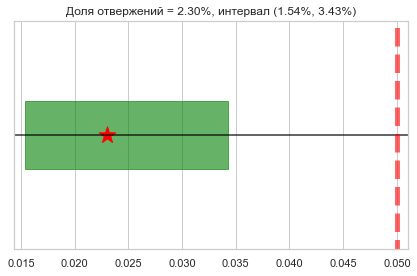

(0.023, 0.01537427693299292, 0.034276450662226676)

In [305]:
# Без эффекта
test(0, 0, 1, 1_000, 1000, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


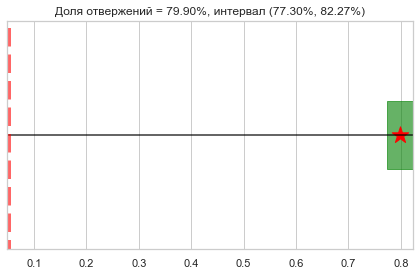

(0.799, 0.7730388134679094, 0.8226727849577289)

In [293]:
# С гомогенным эффектом
test(3_500, 1/3, 1, 1_000, 1000, gen_data)

In [402]:
def new_gen_data(num_users, theta, gamma, scale):
    test_data = generate_raw_data(num_users, pre_period + period + post_period, avg_usage_distr, 
                         shows_up_distr, daily_variation_distr)

    test_data['obs_method'] = test_data['daily_usage']
    test_data['ccd_method'] = test_data['daily_usage']

    weekend_days = [4, 5, 11, 12]

    weekdays_data = test_data[~test_data['day'].isin(weekend_days)].copy()
    prepare_data_obs_exp(weekdays_data, 0, gamma, scale, mode='novelty', 
                         group_column='obs_group', target_column='obs_method')
    prepare_data_ccd_exp(weekdays_data, 0, gamma, scale, 
                         mode='novelty', group_column='ccd_group', 
                         target_column='ccd_method', start_day=pre_period-1)

    weekend_data = test_data[test_data['day'].isin(weekend_days)].copy()
    prepare_data_obs_exp(weekend_data, theta, gamma, scale, mode='novelty', 
                         group_column='obs_group', target_column='obs_method')
    prepare_data_ccd_exp(weekend_data, theta, gamma, scale, 
                         mode='novelty', group_column='ccd_group', 
                         target_column='ccd_method', start_day=pre_period-1)

    test_data = pd.concat([weekdays_data, weekend_data])
    
    return test_data

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:22<00:00,  4.94it/s]


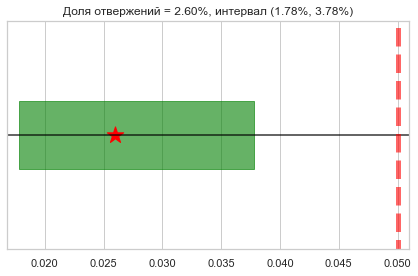

(0.026, 0.017803938201616326, 0.037823828842689936)

In [307]:
# С сезонным эффектом
test(5000, 0, 1, 1_000, 1000, new_gen_data)

Теперь рассмотрим все то же самое, но для cookie-cookie-day подхода

In [310]:
test_data.ccd_group.value_counts() # у нас exp_period = 14 групп

0     150010
1     150010
2     150010
3     150010
4     149996
5     149996
6     149996
7     149996
8     149996
9     149996
10    149996
11    149996
12    149996
13    149996
Name: ccd_group, dtype: int64

In [363]:
def test(theta, gamma, scale, num_tests, num_users, gen_data):
    num_errors = 0
    for test in trange(num_tests):
        test_data = gen_data(num_users, theta, gamma, scale)
        
        num_errors += cookie_cookie_day(test_data, start_day=pre_period - 1, 
                                   end_day=pre_period + exp_period - 1, target_column="ccd_method")
    
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(num_errors, num_tests)
    draw_interval(real_alpha, left_alpha, right_alpha)
    
    return real_alpha, left_alpha, right_alpha

In [403]:
def cookie_cookie_day(sample, start_day, end_day, target_column="daily_usage"):
    sample_day = sample[sample.day == end_day]
    Xtt = sample_day[sample_day.ccd_group == (end_day - start_day - 1)][target_column]
    Yt = sample_day[sample_day.ccd_group == 0][target_column]
    delta = Yt.mean() - Xtt.mean()
    
    var = 2 * Xtt.var() * (end_day - start_day) / len(Xtt)
    tvalue = sps.norm().cdf(delta / np.sqrt(var)) 
    return tvalue < 0.05

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:58<00:00,  5.59it/s]


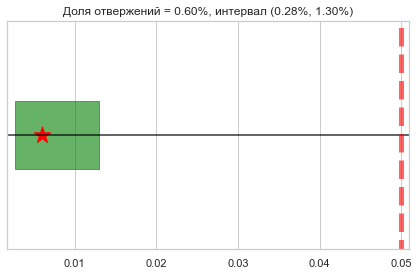

(0.006, 0.0027526691418763736, 0.01302816824185209)

In [398]:
# Без эффекта
num_users = 1000
test(0, 0, 1, 1_000, 1000, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:58<00:00,  5.60it/s]


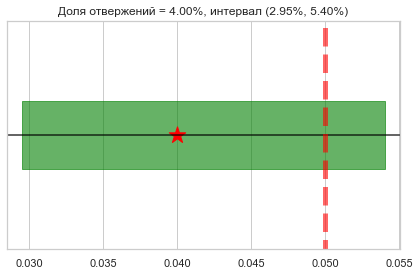

(0.04, 0.02951097368545276, 0.05400964412125796)

In [396]:
# С гомогенным эффектом
test(3_500, 1/3, 1, 1_000, 1000, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:49<00:00,  5.92it/s]


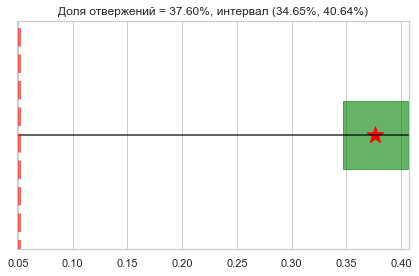

(0.376, 0.34650662606266847, 0.4064424100417492)

In [392]:
# С гомогенным эффектом
test(5_500, 1/3, 1, 1_000, 1000, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:55<00:00,  3.38it/s]


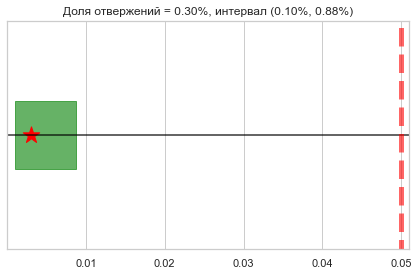

(0.003, 0.0010207838811386195, 0.008783014053503176)

In [399]:
# С сезонным эффектом
test(5000, 0, 1, 1_000, 1000, new_gen_data)

По таким данным, кажется, наблюдательный подход лучше, так как он мощнее. Для одинаковых тета ccd показал результаты хуже. При этом оба подхода применимы, так как реальный уровень значимости меньше 5%

*Вот и закончилась первая практическая задача. Правда же все просто если разобраться в имеющихся функциях? :)*

---
### Задача 2.

*Так так, дай угадаю, ты уже посмотрел(а), что в задаче 6 пунктов? Не спеши расстраиваться и пропускать задачу! Одна довольно простая и увлекательная, в ней подробно расписано, что надо сделать. Вроде даже долгих вычислений и сложных функций тут нет. Так что, го!*

Наконец, давай сравним наш обычный t-test c критерием Вальда в последовательном анализе. На занятии мы уже начали их сравнивать. Возьми используемые там параметры, и убедись, что ты используешь одни и те же гипотезы и одинаковые значения ошибок 1 и 2 рода. Формально, в случае t-test надо рассмотреть только простую альтернативу $\mathsf{H}_1\colon a=a_1$ и рассматривать мощность для нее, что мы и сделали на занятии.

**1.** Теперь предположим, что $\mathsf{H}_0$ верна. Оцени время до принятия решения в последовательном анализе с помощью семплирования и по теоретической формуле.

*Не забудь, что возможные ответы в последовательном анализе несколько отличаются от стандартного подхода, причем имеется симметрия. Если ты это понимаешь, то сможешь легко решить данный пункт на основе предыдущих.*

In [7]:
def calculate_stat(sample, logpdf_0, logpdf_1, cumulative=False):
    '''
    Вычисление статистики критерия.
    
    sample - выборка
    logpdf_0 - функция вычисления логарифма плотности при H_0
    logpdf_1 - функция вычисления логарифма плотности при H_1
    cumulative - вернуть ли кумулятивную статистику или же только итоговую
    '''
    
    z_stats = logpdf_1(sample) - logpdf_0(sample)
    if cumulative:
        return np.cumsum(z_stats, axis=-1)
    else:
        return np.sum(z_stats, axis=-1)

In [8]:
a0, a1 = 0, 0.2  # средние в каждой из гипотез

# вероятности ошибок
alpha = 0.05
beta = 0.2

# пороги, при которых принимаем одну из гипотез
B = (1 - beta) / alpha
A = beta / (1 - alpha)

Смотрим на картинку для маленьких выборок

In [36]:
sample_count = 50  # Количество выборок
sample_size = 100  # Общий размер выборок

size_range = np.arange(sample_size) + 1
samples = np.random.normal(loc=(a0+a1)/2, size=(sample_count, sample_size))

In [37]:
z_stats = calculate_stat(
    samples, 
    sps.norm(loc=a0).logpdf, 
    sps.norm(loc=a1).logpdf, 
    cumulative=True
)

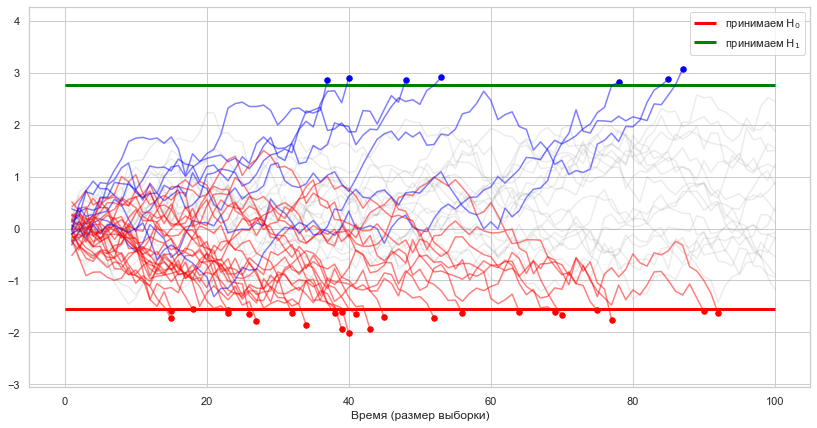

In [38]:
plt.figure(figsize=(14, 7))
for j in range(sample_count):    
    a_stop = size_range[z_stats[j] <= np.log(A)][:1]
    b_stop = size_range[z_stats[j] >= np.log(B)][:1]
    if len(a_stop)>0 and (len(b_stop)==0 or (a_stop[0] < b_stop[0])):
        plt.plot(size_range[:a_stop[0]], z_stats[j][:a_stop[0]], color='red', alpha=0.5)
        plt.scatter(size_range[a_stop[0]-1], z_stats[j][a_stop[0]-1], color='red', s=30)
    elif len(b_stop)>0:
        plt.plot(size_range[:b_stop[0]], z_stats[j][:b_stop[0]], color='blue', alpha=0.5)
        plt.scatter(size_range[b_stop[0]-1], z_stats[j][b_stop[0]-1], color='blue', s=30)
    else:
        plt.plot(size_range, z_stats[j], color='gray', alpha=0.15)

plt.hlines(np.log(A), 0, sample_size, lw=3, color='red', label='принимаем $\mathsf{H}_0$')
plt.hlines(np.log(B), 0, sample_size, lw=3, color='green', label='принимаем $\mathsf{H}_1$')
plt.ylim((np.log(A)-1.5, np.log(B)+1.5))
plt.xlabel('Время (размер выборки)')
plt.legend();

Сравниваем уже для больших выборок

In [405]:
sample_count = 10_000  # Количество выборок
sample_size = 2_000  # Общий размер выборок

size_range = np.arange(sample_size) + 1
# Генерируем выборку разностей, поэтому дисперсия в 2 раза больше
samples = np.random.normal(loc=a1, scale=np.sqrt(2), size=(sample_count, sample_size))

# Считаем статистики критерия Вальда
z_stats = calculate_stat(
    samples, 
    sps.norm(loc=a0, scale=np.sqrt(2)).logpdf, 
    sps.norm(loc=a1, scale=np.sqrt(2)).logpdf, 
    cumulative=True
)

In [29]:
# Моменты времени, когда происходит отвержение гипотезы H_0 (а это происходит, когда мы выходим за черту сверху)
is_reject = (z_stats >= np.log(B)) * size_range
# Если нет принятия, ставим большое число
is_reject[is_reject == 0] = sample_size + 1
# Выбираем минимум для каждой выборки
reject_time = np.min(is_reject, axis=1)

# Доля выборок, в которых принятия не было
(reject_time == sample_size + 1).mean()

0.0006

In [30]:
reject_time.mean() # размер выборки в последовательном анализе

279.8325

In [31]:
def get_sample_size(alpha, beta, mde, var_x, var_y):
    '''Расчитывает размер выборки для детектирование MDE
    
    :param alpha: желаемая ошибка первого рода
    :param beta: желаемая мощность
    :param mde: необходимый эффект
    :param var_x, var_y: дисперсии выборок
    :returns: необходимый размер выборки
    '''
    
    q_sum = sps.norm.ppf(1 - alpha) + sps.norm.ppf(beta)
    return np.ceil((q_sum ** 2) * (var_x + var_y) / (mde * mde)).astype(int)

In [32]:
get_sample_size(alpha=0.05, beta=0.8, mde=a1, var_x=1, var_y=1) # аналитическая формула

310

Итого в последовательном анализе требуется чуть меньше времени для принятия решения

**2.** Давай разберемся, можно ли совмещать два подхода &mdash; обычную процедуру проверки гипотез с критерием t-test и процедуру последовательного анализа с критерием Вальда. Для этого построим следующий критерий. Зафиксируем число $n$. До тех пор, пока размер выборки меньше $n$, будем пользоваться последовательным анализом и останавливать нашу процедуру в случае принятия одной из гипотез. Когда в выборке станет ровно $n$ объектов, а процедура последовательного анализа еще не завершилась, остановим ее и применим обычный t-test. Цель &mdash; оценить вероятность ошибки 1 рода у такой комбинации процедур.

*Указание.* Удобнее сразу сгенерировать выборки размера $n$, применить оба критерия независимо, а затем для наглядности построить <a href="https://miptstats.github.io/courses/python/10_pandas2.html#4.1-Функция-pd.crosstab">crosstab</a> по ответам каждого критерия, из нее уже можно получить ответ на вопрос задачи.

In [86]:
sample_count = 1000  # Количество выборок
n = 2000  # Размер каждой выборки

samples = np.random.normal(size=(sample_count, n))
cumulative_means = np.cumsum(samples, axis=1)

t_bound = np.sqrt(n) * sps.norm.ppf(1-alpha/2)
is_reject_t_test = np.abs(cumulative_means[:, -1]) > t_bound
is_reject_t_test.mean()

0.059

Те, которые отвергаются в конце с помощью t-test

In [104]:
z_stats = calculate_stat(
    samples, 
    sps.norm(loc=a0).logpdf, 
    sps.norm(loc=a1).logpdf, 
    cumulative=True
)

# 0 - ничего не происходит, 1 - принимается Н_0, 2 - принимается Н_1
mat = (z_stats >= np.log(B)) * 2 + (z_stats <= np.log(A))

In [105]:
is_reject = np.array(list(map(lambda arr: arr[arr != 0][0] == 2, mat)))
is_reject.mean()

0.039

Доля тех, для которых в начале была принята гипотеза H_1

In [106]:
pd.crosstab(is_reject_t_test, is_reject, margins=True)

col_0,False,True,All
row_0,,,
False,906,35,941
True,55,4,59
All,961,39,1000


Не знаю, зачем тут проводить независимо, а потом строить crosstab, потому что нам не надо применять t-test для случаев, в которых для последовательного анализа была принята гипотеза H_0 где-то в середине

In [107]:
is_H_0 = np.array(list(map(lambda arr: arr[arr != 0][0] == 1, mat)))
is_H_0.mean()

0.961

Во всех остальных случаях приняли H_0 еще до конца. Так что ошибка первого рода тут такая же, как у последовательного критерия, то есть 0.039 в нашем случае

Повтори эту процедуру для нескольких $n$ и визуализируй зависимость. 
Не забудь сделать вывод.

In [127]:
rejected_ratio = []
for n in trange(30, 2000, 20):
    samples = np.random.normal(size=(sample_count, n))
    z_stats = calculate_stat(
        samples, 
        sps.norm(loc=a0).logpdf, 
        sps.norm(loc=a1).logpdf, 
        cumulative=True
    )
    
    # 0 - ничего не происходит, 1 - принимается Н_0, 2 - принимается Н_1
    mat = (z_stats >= np.log(B)) * 2 + (z_stats <= np.log(A))
    lst = np.array(list(map(lambda arr: 0 if len(arr[arr != 0]) == 0 else 
                            2 * (arr[arr != 0][0] == 2) + (arr[arr != 0][0] == 1), mat)))
    
    cumulative_means = np.cumsum(samples, axis=1)
    t_bound = np.sqrt(n) * sps.norm.ppf(1-alpha/2)
    lst[lst == 0] = 1 + np.abs(cumulative_means[lst == 0, -1]) > t_bound
    rejected_ratio.append((lst == 2).sum() / len(lst))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:10<00:00,  9.38it/s]


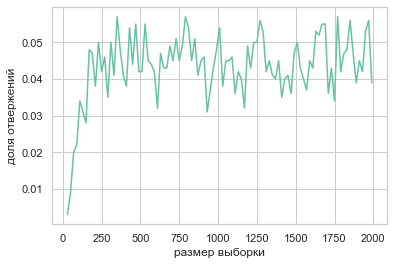

In [132]:
plt.plot(range(30,2000,20), rejected_ratio)
plt.xlabel('размер выборки')
plt.ylabel('доля отвержений')
plt.show()

В целом, все применимо, так как за 5% почти не выходим (и то на чуть-чуть, что можно списать на статистическую погрешность). Для больших n последовательный анализ успевает вынести решение для всех выборок, поэтому с ошибкой первого рода все хорошо. Для маленьких n мы в конце применяем обычный t-test, если последовательный анализ еще не успел вынести решение.

**3.** Теперь поймем, какая процедура мощнее. На занятии мы установили "стандартные" параметры. Возьми размер выборки $n$, который дает мощность 80% по формуле MDE для стандартного t-test. Промоделируй выборки при справедливости $\mathsf{H}_1$ и посчитай долю случаев, в которых процедура последовательного анализа принимает $\mathsf{H}_1$ до момента времени $n$ включительно. Сделай вывод относительно мощности исследуемых процедур.

*Не забывай указания предыдущих пунктов и про код с занятия.*

In [410]:
sample_count = 10_000  # Количество выборок
sample_size = 2_000  # Общий размер выборок

size_range = np.arange(sample_size) + 1
# Генерируем выборку разностей, поэтому дисперсия в 2 раза больше
samples = np.random.normal(loc=a1, scale=np.sqrt(2), size=(sample_count, sample_size))

# Считаем статистики критерия Вальда
z_stats = calculate_stat(
    samples, 
    sps.norm(loc=a0, scale=np.sqrt(2)).logpdf, 
    sps.norm(loc=a1, scale=np.sqrt(2)).logpdf, 
    cumulative=True
)

In [242]:
n = get_sample_size(alpha=0.05, beta=0.8, mde=a1, var_x=1, var_y=1) # аналитическая формула
n

310

In [243]:
mat = (z_stats >= np.log(B)) * 2 + (z_stats <= np.log(A))

In [137]:
is_reject = np.array(list(map(lambda arr: arr[arr != 0][0] == 2, mat)))
is_reject.mean()

0.8164

Это доля отвержений в целом, теперь нам нужна доля отвержений до момента n:

In [252]:
is_reject_ = np.array(list(map(lambda arr: 0 if len(arr[arr != 0]) == 0 else arr[arr != 0][0] == 2, mat[:, :n+1])))
is_reject_.mean()

0.6543

Кажется, мощность лучше у обычного t-test, если мы завершаем все на итерации n, но зато в случае с последовательным анализом мы в большинстве случаев детектируем эффект раньше, чем наступил момент времени n

**4.** На практике наблюдения могут приходить батчами по несколько объектов сразу. В таком случае нельзя устанавливать на них какой-либо порядок, применяя последовательный критерий Вальда по одному, необходимо добавлять сразу весь батч.

Исследуй, как меняется мощность процедуры последовательного анализа в зависимость от количества объектов в батче.

*Ты же понимаешь, что надо взять код из предыдущего пункта и указать один параметр?*

Мы так же прибавляем к статистике значения, просто для одного батча мы прибавляем его весь сразу и не считаем посередине z_stat, а только лишь после прибавляения всего батча

In [418]:
powers = []
for batch_size in range(1, 501):
    mat = (z_stats[::batch_size] >= np.log(B)) * 2 + (z_stats[::batch_size] <= np.log(A))
    is_reject_ = np.array(list(map(lambda arr: 0 if len(arr[arr != 0]) == 0 else 
                                   arr[arr != 0][0] == 2, mat)))
    powers.append(is_reject_.mean())

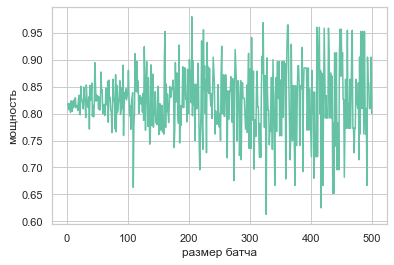

In [419]:
plt.plot(range(1, 501), powers)
plt.xlabel('размер батча')
plt.ylabel('мощность')
plt.show()

Чем меньше батчей (чем больше размер батча), тем все менее точно, что логично. То есть мы видим, что дисперсия на графике возросла с ростом размера батча, так как мы уже не так часто проверяем гипотезу, а раз в batch_size итераций. При этом внутри батча мы могли уже выйти за трешхолд, но к концу могли войти обратно. Следовательно, решения по таким данным еще не будет принято в случае с батчами (а без батчей уже было бы принято). Колебания все еще на уровне 80%, как и должно быть

**5.** Наконец, давай вспомним, что последовательно приходящие данные не всегда являются выборкой, часто это временной ряд. Провалидируй процедуру последовательного анализа применительно к временным рядам.

*На занятии был код генерации временных рядов, используй его. И, конечно, код предыдущих пунктов задачи*.

In [166]:
sample_size = 10_000  # Количество объектов
time_size = 2_000  # Длина временного ряда для каждого объекта

In [175]:
def generate_time_series(sample_size=50, time_size=10):
    '''
    Генерация временных рядов - недельные продажи по магазинам.
    
    sample_size - количество магазинов
    time_size - количество недель
    
    '''
    
    means = np.random.gamma(size=(sample_size, 1), shape=5, scale=200)
    noise = np.random.normal(size=(sample_size, time_size), scale=10)
    sample = means + noise
    
    return sample

In [264]:
samples = generate_time_series(sample_size=sample_size, time_size=time_size)

In [219]:
samples.shape

(10000, 2000)

In [229]:
# Считаем статистики критерия Вальда
z_stats = calculate_stat(
    samples, 
    sps.gamma(5, loc=1000, scale=np.sqrt(200 **2)).logpdf, 
    sps.gamma(5, loc=1050, scale=np.sqrt(200 **2)).logpdf, 
    cumulative=True
)

C:\Users\73F5~1\AppData\Local\Temp/ipykernel_26588/2507798616.py:11: RuntimeWarning: invalid value encountered in subtract
  z_stats = logpdf_1(sample) - logpdf_0(sample)


In [230]:
mat = (z_stats >= np.log(B)) * 2 + (z_stats <= np.log(A))
is_reject = np.array(list(map(lambda arr: 0 if len(arr[arr != 0]) == 0 else arr[arr != 0][0] == 2, mat)))
is_reject.mean()

0.0496

То есть критерий применим, так как ошибка первого рода вблизи 5%

In [263]:
samples_1 = generate_time_series(sample_size=sample_size, time_size=time_size) * 1.05
samples_2 = generate_time_series(sample_size=sample_size, time_size=time_size)

z_stats = calculate_stat(
    samples_1 - samples_2, 
    sps.gamma(1, loc=0, scale=np.sqrt(2 * 200 ** 2)).logpdf, 
    sps.gamma(1, loc=50, scale=np.sqrt(2 * 200 ** 2)).logpdf, 
    cumulative=True
)

mat = (z_stats >= np.log(B)) * 2 + (z_stats <= np.log(A))
is_reject = np.array(list(map(lambda arr: 0 if len(arr[arr != 0]) == 0 else arr[arr != 0][0] == 2, mat)))
is_reject.mean()

C:\Users\73F5~1\AppData\Local\Temp/ipykernel_26588/2507798616.py:11: RuntimeWarning: invalid value encountered in subtract
  z_stats = logpdf_1(sample) - logpdf_0(sample)


0.4895

Мощность не самая высокая, но приемлемая

**6.** Не забудь сделать выводы.

В целом, в некоторых случаях последовательный критерий позволяет нам уменьшить количество требуемых объектов, однако мы видим, что мощность у такого критерия на моменте времени n еще не дотягивает до мощности t-test, то есть в некоторых случаях (в меньшенстве) надо ждать дольше, но зато в таком методе мы можем принять Н_0 или Н_1 гораздо раньше, что может играть свою роль (положительную). Мощность не падает при росте размера батчей (если общее количество батчей остается довольно большим), так как для одного батча мы все равно прибавляем к статистике все значения, просто в любом порядке и при этом не считаем z_stat посередине, а только в конце.

Вот и все, еще одно задание закончилось, вроде же хорошо мы вместе решили задачки, правда?)

А теперь, как и раньше, все перепроверь, поработай над качеством оформления и отправляй боту. Не забудь покушать, и на лекцию!